In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline

In [2]:
velsDataDF = pandas.read_csv( "../data/processed-vels-geomag.txt", sep=' ',\
                            infer_datetime_format=True,\
                            parse_dates=["date"])
# velsDataDF = pandas.read_csv( "../data/processed-vels-geomag.txt", sep=' ')
velsDataDF.head()

,azim,azimStd,delMLT,endPtMLAT,endPtNormMLT,goodFit,MLAT,normMLT,vSaps,velSTD,...,minute,dst_date,dst_index,dst_bin,datetimeStr,AE,AL,AO,AU,count
0,-3.387108,NaN,NaN,63.05,-0.90,False,63.0,0.0,902.535876,NaN,...,24,2012-10-23 07:00:00,4.0,"(-10, 10]",20121023-07-24,121,-98,-38,23,284
1,-3.516834,NaN,NaN,63.04,-0.66,False,63.0,0.0,659.606637,NaN,...,26,2012-10-23 07:00:00,4.0,"(-10, 10]",20121023-07-26,116,-100,-42,16,284
2,-9.533716,NaN,NaN,63.12,-0.69,False,63.0,0.0,704.274601,NaN,...,28,2012-10-23 07:00:00,4.0,"(-10, 10]",20121023-07-28,106,-87,-34,19,284
3,-18.011539,3.652241,1.0,NaN,NaN,True,63.0,0.0,441.631334,57.540267,...,8,2011-09-20 06:00:00,-24.0,"(-25, -10]",20110920-06-08,110,-52,3,58,284
4,-18.011539,3.652241,1.0,NaN,NaN,True,63.0,0.0,441.631334,57.540267,...,8,2011-09-20 06:00:00,-24.0,"(-25, -10]",20110920-06-08,110,-52,3,58,284


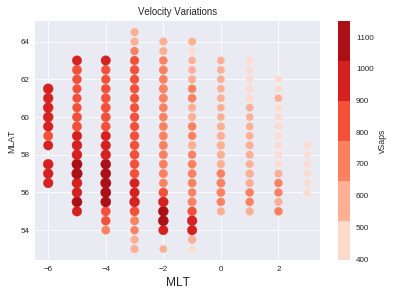

In [3]:
# We'll now divide data into MLT/MLAT bins and get some stats
mltMlatMeanDF = velsDataDF.groupby( [ "normMLT", "MLAT" ] ).mean().reset_index()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=mltMlatMeanDF["vSaps"]/10, cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocity Variations" )
plt.savefig("../figs/meanVelMLATMLT.pdf",bbox_inches='tight')

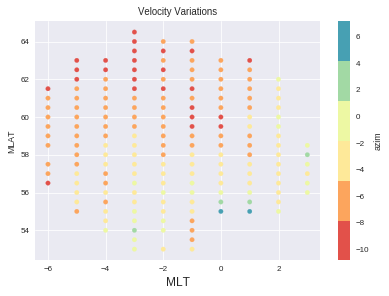

In [7]:
mltMlatMeanDF = velsDataDF.groupby( [ "normMLT", "MLAT" ] ).mean().reset_index()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Spectral"))

# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=20, cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocity Variations" )
plt.savefig("../figs/meanAzimMLATMLT.pdf",bbox_inches='tight')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if sys.path[0] == '':


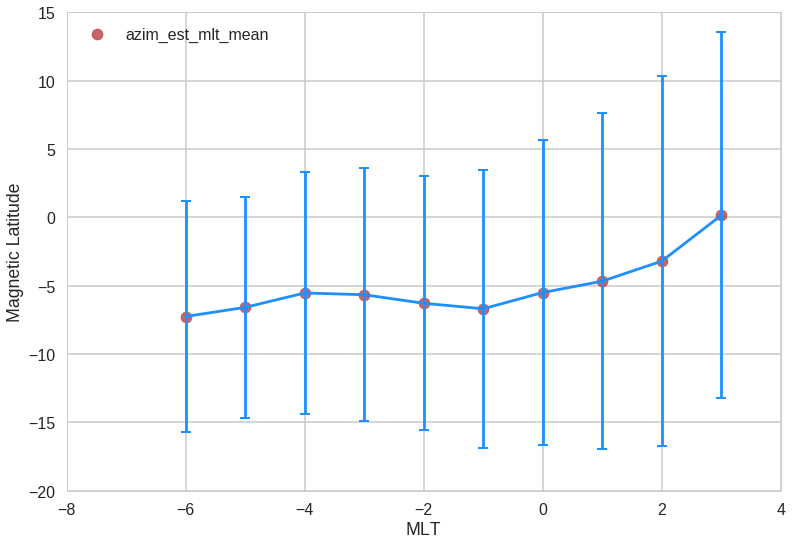

In [5]:
# Plot Mean and Std of Azims vs MLT!
azimMLTMeanDF = velsDataDF.groupby( [ "normMLT" ] ).mean()[ "azim" ].reset_index()
azimMLTMeanDF.columns = [ "normMLT", "azim_est_mlt_mean" ]
azimMLTStdDF = velsDataDF.groupby( [ "normMLT" ] ).std()[ "azim" ].reset_index()
azimMLTStdDF.columns = [ "normMLT", "azim_est_mlt_std" ]
azimMLTMeanDF = pandas.merge( azimMLTMeanDF, azimMLTStdDF, on=[ "normMLT" ] )
azimMLTMeanDF["azim_std"] = azimMLTMeanDF["azim_est_mlt_std"].fillna(0.5)
# seaborn styling
sns.set_style("whitegrid")
sns.set_context("poster")

azimMLTMeanDF = azimMLTMeanDF.sort(["normMLT"])
plt.scatter(azimMLTMeanDF['normMLT'],
            azimMLTMeanDF['azim_est_mlt_mean'],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124)
plt.errorbar(azimMLTMeanDF['normMLT'],\
             azimMLTMeanDF['azim_est_mlt_mean'],\
             yerr=azimMLTMeanDF['azim_est_mlt_std'], \
             color='dodgerblue', label='', capthick=2., capsize=5.)
plt.xlim( [-8,4] )
plt.ylim( [-20,15] )
plt.xlabel("MLT")
plt.ylabel("Magnetic Latitude")
plt.legend()
plt.savefig("../figs/meanStdAzim.pdf",bbox_inches='tight')

In [6]:
print velsDataDF[ velsDataDF["goodFit"] ][["vSaps", "normMLT"]].groupby( [ "normMLT" ] ).std()

              vSaps
normMLT            
-6.0     346.324230
-5.0     360.811742
-4.0     311.560593
-3.0     268.948780
-2.0     263.093498
-1.0     248.420830
 0.0     204.277084
 1.0     180.945387
 2.0     180.378138
 3.0     133.921014
